# 梯度下降最大似然估计正态分布的均值和方差

onlytiancai 2025-08-18

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# 解决中文乱码问题（使用SimHei黑体）
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号

# 设置随机种子保证结果可复现
np.random.seed(42)

In [2]:
def show_plot(mu_hist, sigma_hist, steps):
    x = np.linspace(-1, 15, 500)
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    fig.subplots_adjust(hspace=0.4, wspace=0.3)
    
    for i, step in enumerate(steps):
        ax = axes[i]
        ax.hist(data_normal, bins=30, density=True, alpha=0.3, color='skyblue', label="数据")
        ax.plot(x, stats.norm.pdf(x, 5, 2), "g--", lw=2, label="真实分布")
        mu, sigma = mu_hist[step], sigma_hist[step]
        ax.plot(x, stats.norm.pdf(x, mu, sigma), "b-", lw=2, label="估计分布")
        ax.set_title(f"Normal step={step+1}\nμ={mu:.2f}, σ={sigma:.2f}")
        ax.legend()
    
    # Normal 收敛曲线
    ax = axes[3]
    ax.plot(mu_hist, label="μ 估计")
    ax.axhline(5, color='g', linestyle="--", label="μ 真值")
    ax.plot(sigma_hist, label="σ 估计")
    ax.axhline(2, color='r', linestyle="--", label="σ 真值")
    ax.set_title("Normal 参数收敛")
    ax.legend()

## 一、默认梯度下降

学习率为 0.002， sigma 初始化为 5，迭代 50 次，即可让 mu 和 sigma 收敛到真实值附近

In [3]:
data_normal = np.random.normal(loc=5, scale=2, size=500)

def mle_normal(data, lr=0.002, iterations=50, mu_est=0.0, sigma_est=5):
    mu_hist, sigma_hist = [], []
    for _ in range(iterations):
        grad_mu = np.sum((data - mu_est) / sigma_est**2)
        grad_sigma = np.sum(((data - mu_est)**2 - sigma_est**2) / sigma_est**3)
        mu_est += lr * grad_mu
        sigma_est += lr * grad_sigma
        mu_hist.append(mu_est)
        sigma_hist.append(sigma_est)
    return mu_hist, sigma_hist

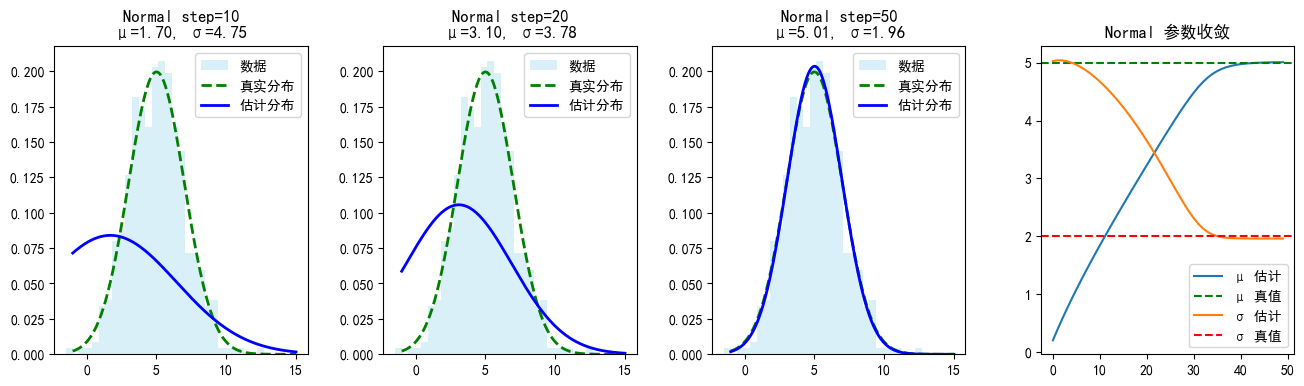

In [4]:
mu_hist, sigma_hist = mle_normal(data_normal)    
show_plot(mu_hist, sigma_hist, [9, 19, 49])

## 二、默认梯度下降对初始值很敏感

但是当 sigma 初始化为 1 时，迭代 50 次，sigma 几乎没收敛

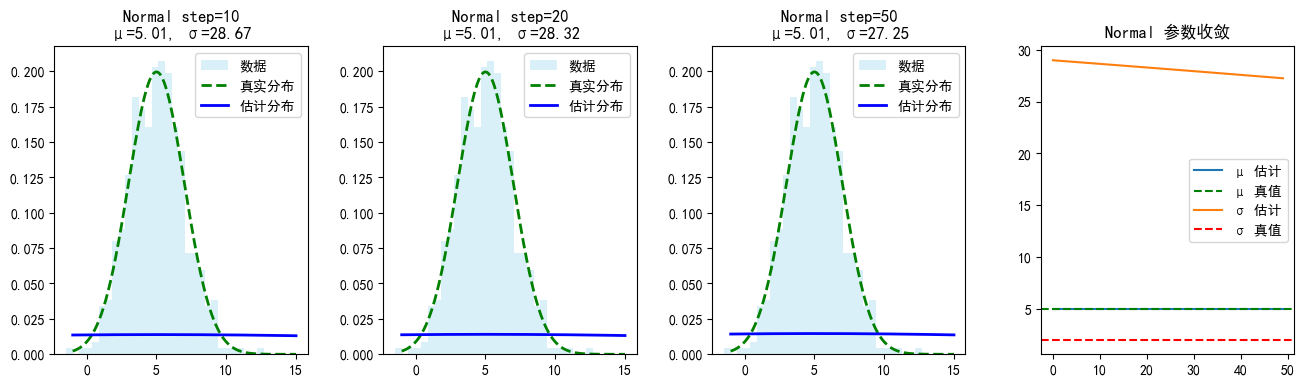

In [5]:
mu_hist, sigma_hist = mle_normal(data_normal, sigma_est=1)    
show_plot(mu_hist, sigma_hist, [9, 19, 49])

> sigma_est 初始化为1时，收敛非常慢，为什么？


你遇到的问题，其实是 **梯度下降对初始值和梯度尺度非常敏感** 的一个典型案例。我们来仔细分析你的代码和数学原理。

---

### 1. 你在做什么

你的 `mle_normal` 函数是在用梯度上升（因为是 MLE）估计正态分布参数 $\mu$ 和 $\sigma$：

梯度公式（对数似然）：

$$
\frac{\partial \ell}{\partial \mu} = \sum_i \frac{x_i - \mu}{\sigma^2}, \quad
\frac{\partial \ell}{\partial \sigma} = \sum_i \frac{(x_i - \mu)^2 - \sigma^2}{\sigma^3}
$$

你的更新公式就是：

```python
mu_est += lr * grad_mu
sigma_est += lr * grad_sigma
```

---

### 2. 梯度的尺度问题

对 $\mu$ 的梯度：

$$
\text{grad}_\mu = \sum_i \frac{x_i - \mu}{\sigma^2}
$$

对 $\sigma$ 的梯度：

$$
\text{grad}_\sigma = \sum_i \frac{(x_i - \mu)^2 - \sigma^2}{\sigma^3}
$$

注意：

* $\sigma$ 出现在分母的 **二次方或三次方**。
* 当你初始化 `sigma_est = 5` 时，梯度：

$$
\text{grad}_\sigma \sim \sum_i \frac{(x_i - \mu)^2 - 25}{125} \sim O(1)
$$

尺度适中，学习率 0.002 可以快速收敛。

* 当你初始化 `sigma_est = 1` 时，梯度：

$$
\text{grad}_\sigma \sim \sum_i \frac{(x_i - \mu)^2 - 1}{1} \sim O(n \cdot (\text{data variance} - 1)) \sim 500 \cdot (4 - 1) = 1500
$$

✅ 梯度非常大，而你用的学习率还是 0.002，导致更新幅度：

$$
\Delta \sigma = 0.002 \cdot 1500 \approx 3
$$

你看起来是“慢”，其实是**震荡/数值不稳定**。如果学习率调小，收敛会稳定，但会慢很多；如果学习率太大，可能会发散。

---

### 3. 为什么 `sigma_est = 5` 快

因为真实 `sigma=2`，初始化 `5` 时：

$$
\sigma_{grad} = \sum_i \frac{(x_i - \mu)^2 - 25}{125} \sim \sum_i \frac{4 - 25}{125} \sim -0.672
$$

梯度非常小，学习率 0.002 更新刚好合适 → 平滑收敛。

---

### 4. 解决方法

1. **调整学习率**：

   * 当 $\sigma$ 很小，梯度很大，需要用更小的学习率：

   ```python
   lr_sigma = 1e-5
   ```

   或者对 $\mu$ 和 $\sigma$ 使用不同学习率。

2. **参数变换**：

   * 对 $\sigma$ 做 log 变换，用 $\log \sigma$ 更新：

   ```python
   log_sigma = np.log(sigma_est)
   grad_log_sigma = np.sum(((data - mu_est)**2 - sigma_est**2) / sigma_est**2)
   log_sigma += lr * grad_log_sigma
   sigma_est = np.exp(log_sigma)
   ```

   * 这样梯度就不会因为 $\sigma$ 太小而爆炸。

3. **标准化数据**：

   * 让数据方差接近 1，可以减少梯度数值差异。

---

### ✅ 总结

* 收敛速度差异主要原因是 **梯度的尺度依赖于 sigma 的初始值**。
* 当 `sigma_est` 太小，梯度非常大，固定学习率导致更新不稳定 → 表现为慢或者震荡。
* 最稳妥的方法是 **对 sigma 做 log 变换** 或 **使用自适应学习率**。

## 三、使用对数参数化改进默认梯度下降

改进后，可以看到当 sigma 初始值为 1 时，迭代 50 次也能收敛，但收敛曲线波动很大

In [6]:
def mle_normal_logsigma(data, lr=0.002, iterations=50, mu_est = 0.0, sigma_est=1):    
    log_sigma_est = np.log(sigma_est)  # 初始化 sigma 的对数
    mu_hist, sigma_hist = [], []

    for _ in range(iterations):
        sigma_est = np.exp(log_sigma_est)  # 当前 sigma
        # 梯度公式（对 log(sigma)）
        grad_mu = np.sum((data - mu_est) / sigma_est**2)
        grad_log_sigma = np.sum(((data - mu_est)**2 - sigma_est**2) / sigma_est**2)

        # 更新参数
        mu_est += lr * grad_mu
        log_sigma_est += lr * grad_log_sigma

        mu_hist.append(mu_est)
        sigma_hist.append(sigma_est)

    return mu_hist, sigma_hist

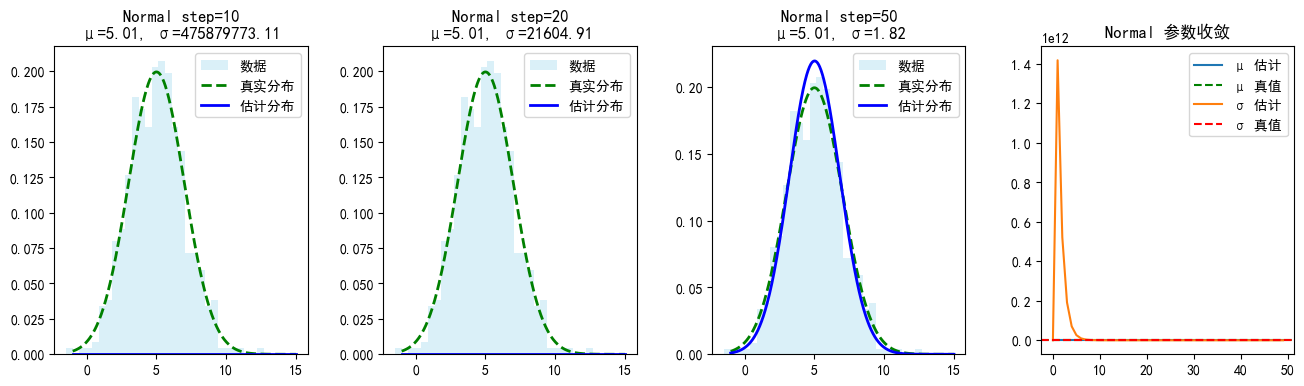

In [7]:
mu_hist, sigma_hist = mle_normal_logsigma(data_normal, sigma_est=1)    
show_plot(mu_hist, sigma_hist, [9, 19, 49])

> 为什么收敛曲线看到sigma先是特别大，然后才慢慢降低到2？

完全可以理解，这是 **梯度方向导致的“先涨后降”现象**，并不是算法出错，而是 MLE 梯度本身的性质。我们分析一下你的情况：

---

### 1. 当前梯度公式回顾

你更新的 log-sigma 梯度为：

$$
\text{grad}_{\log \sigma} = \sum_i \frac{(x_i - \mu)^2 - \sigma^2}{\sigma^2}
$$

当你初始化：

$$
\sigma_{\text{est}} = 1 \quad (\text{所以 } \log\sigma_{\text{est}} = 0)
$$

---

### 2. 为什么 sigma 先变大

* 数据真实方差大约是 $\sigma^2 = 4$。
* 初始 sigma 很小：1
  $(x_i - \mu)^2 - \sigma^2 \approx 4 - 1 = 3$
* 梯度：

$$
\text{grad}_{\log \sigma} \approx \sum_i \frac{3}{1} = 500 \cdot 3 = 1500
$$

* 更新：

$$
\Delta \log \sigma = lr \cdot 1500
$$

* 因为学习率不够小，第一次迭代就会让 log-sigma **快速跃升** → sigma 变得非常大。

也就是说，梯度方向告诉算法：“你现在太小了，要迅速增大 sigma”。所以你看到曲线先上升到很大，然后才慢慢回落到真实值 2。

---

### 3. 为什么最终会回到 2

* 当 sigma 变大后，梯度减小甚至变负，更新方向改变：

$$
(x_i - \mu)^2 - \sigma^2 < 0 \quad \text{时，梯度变负}
$$

* sigma 会从过大的值慢慢降低，最终稳定在真实 MLE 解 $\sigma \approx 2$。

---

### 4. 如何改善收敛曲线

1. **降低学习率**：让 sigma 不会在第一步跳得太大。

   ```python
   lr = 1e-4
   ```
2. **用自适应优化器**（如 Adam）：可以自动调整梯度步长，避免过冲。
3. **初始化更接近真实方差**：例如用样本标准差作为初始 sigma。

---

总结：

> sigma 先升高再降低，是梯度自然作用的结果：初始 sigma 太小导致 log-sigma 梯度非常大，一开始会“跳过头”，之后再慢慢调整到真实值。降低学习率或者用自适应优化器可以让曲线更平滑。

## 四、平滑收敛曲线：减小学习率

可以看到 sigma 没有升特别高，但迭代50次，并没有收敛到 2

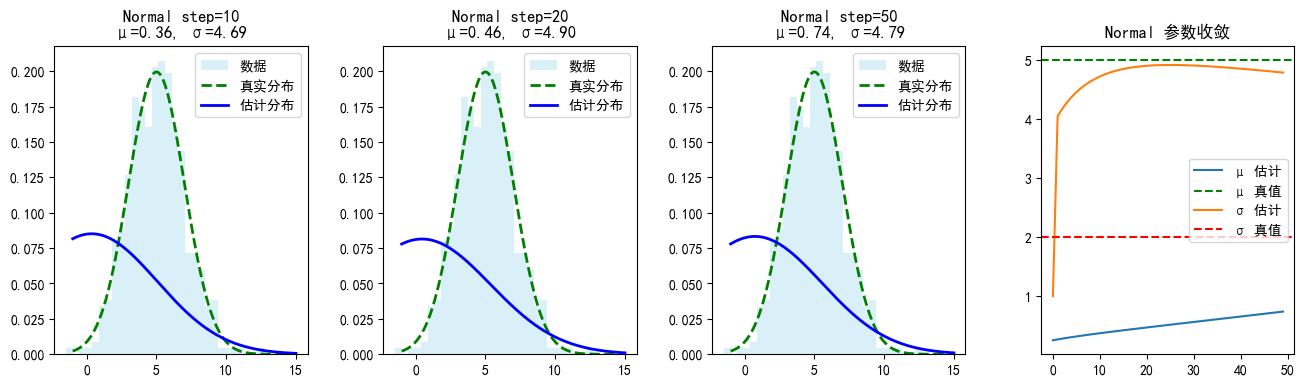

In [8]:
mu_hist, sigma_hist = mle_normal_logsigma(data_normal, lr=1e-4, sigma_est=1)    
show_plot(mu_hist, sigma_hist, [9, 19, 49])

## 五、平滑收敛曲线：Adam 自适应步长

In [9]:
def mle_normal_adam(data, lr=0.01, iterations=50, beta1=0.9, beta2=0.999, eps=1e-8, sigma_est=1):
    mu_est = 0.0
    log_sigma_est = np.log(sigma_est)  # sigma 初始化为 1
    mu_hist, sigma_hist = [], []

    # Adam 一阶和二阶矩初始化
    m_mu, v_mu = 0.0, 0.0
    m_logsigma, v_logsigma = 0.0, 0.0

    for t in range(1, iterations + 1):
        sigma_est = np.exp(log_sigma_est)

        # 梯度
        grad_mu = np.sum((data - mu_est) / sigma_est**2)
        grad_log_sigma = np.sum(((data - mu_est)**2 - sigma_est**2) / sigma_est**2)

        # 更新一阶、二阶矩
        m_mu = beta1 * m_mu + (1 - beta1) * grad_mu
        v_mu = beta2 * v_mu + (1 - beta2) * (grad_mu**2)
        m_logsigma = beta1 * m_logsigma + (1 - beta1) * grad_log_sigma
        v_logsigma = beta2 * v_logsigma + (1 - beta2) * (grad_log_sigma**2)

        # 偏差校正
        m_mu_hat = m_mu / (1 - beta1**t)
        v_mu_hat = v_mu / (1 - beta2**t)
        m_logsigma_hat = m_logsigma / (1 - beta1**t)
        v_logsigma_hat = v_logsigma / (1 - beta2**t)

        # Adam 更新
        mu_est += lr * m_mu_hat / (np.sqrt(v_mu_hat) + eps)
        log_sigma_est += lr * m_logsigma_hat / (np.sqrt(v_logsigma_hat) + eps)

        mu_hist.append(mu_est)
        sigma_hist.append(np.exp(log_sigma_est))

    return mu_hist, sigma_hist


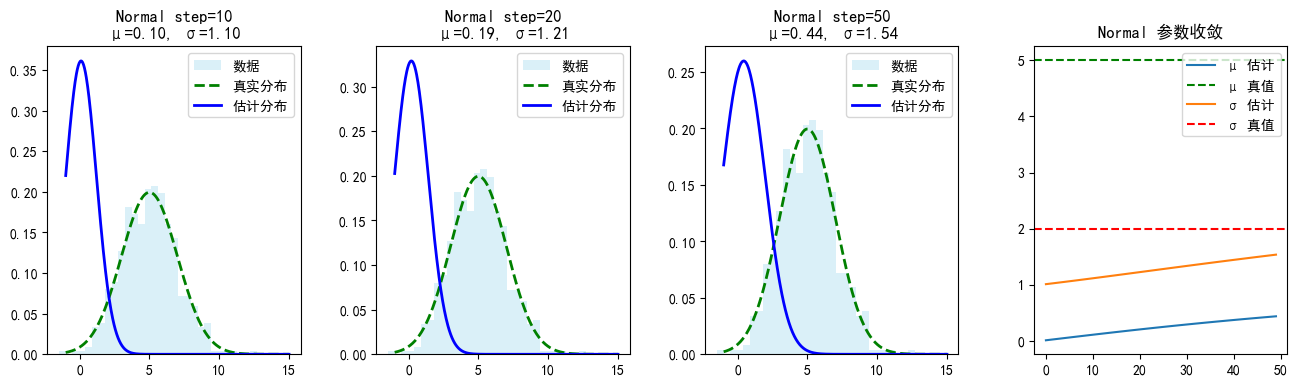

In [10]:
mu_hist, sigma_hist = mle_normal_adam(data_normal, sigma_est=1)    
show_plot(mu_hist, sigma_hist, [9, 19, 49])

即使使用了 adam 优化器，迭代50次也没有让sigma收敛到2附近

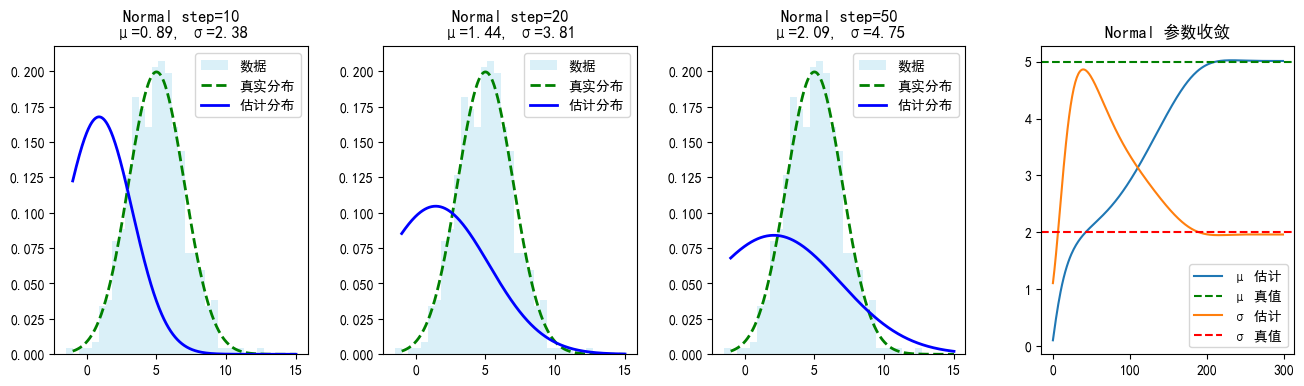

In [11]:
mu_hist, sigma_hist = mle_normal_adam(data_normal, lr=0.1, iterations=300, sigma_est=1)    
show_plot(mu_hist, sigma_hist, [9, 19, 49])

增大学习率到0.1，迭代次数到300次，才能看到 adam 优化器版本让 sigma 收敛到 2